# 2. Classify image using PyCaffe

PyCaffe를 이용하여 Python 내부에서 caffe 모델을 Classifier로 사용하는 방법을 소개합니다.

Caffe는 Model Zoo(https://github.com/BVLC/caffe/wiki/Model-Zoo)에 다양한 모델을 공개하고 있습니다. 본 예제에서는 ILSVRC 2012(ImageNet 2012) 데이터로부터 학습된 Caffe-reference 모델을 사용하여 주어진 이미지를 분류합니다.

본 예제는 크게 두 Part로 나누어져 있습니다.
1. PyCaffe를 사용한 이미지 분류
2. 이미지가 입력되었을 때 각 layer의 activation을 visualization하는 방법

## 1. Image classification
### 1-1. Import libraries

* 먼저 필요한 Library들을 import 해야 합니다. 필요한 library는 matrix연산에 최적화된 numpy와 visualization을 위한 matlotlib, 그리고 caffe가 필요합니다.
* 차후 분류된 image의 class를 출력하기 위해서 imagenet dataset의 label-class index 매핑 정보를 불러옵니다.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import caffe
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

labels_file = './caffe/data/ilsvrc12/synset_words.txt' # class index와 class name 매핑 정보
labels = np.loadtxt(labels_file, str, delimiter='\t') 

/root/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/root/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/root/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


* 학습된 reference_caffenet은 ./caffe/models/bvlc_reference_caffenet에 저장되어 있습니다

* If needed, download the reference model ("CaffeNet", a variant of AlexNet).

In [2]:
!ls ./caffe/models/bvlc_reference_caffenet

bvlc_reference_caffenet.caffemodel  readme.md	     train_val.prototxt
deploy.prototxt			    solver.prototxt


### 1-2. Load net and set up input preprocessing

* caffe.set_mode_cpu()를 사용하여 CPU를 사용하여 연산함을 명시합니다.
* PyCaffe의 caffe.Net기능을 이용하여 학습된 모델(reference_caffenet)을 불러옵니다.
* caffe.Net를 사용하여 모델을 불러올 때, caffe.TEST를 명시하여 dropout이 비활성화 되도록 합니다.

In [3]:
caffe.set_mode_cpu()

model_def = './caffe/models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = './caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # 모델 정의 파일 경로 (.prototxt)
                model_weights,  # 모델 weights 파일 경로 (.caffemodel)
                caffe.TEST)     # Test mode임을 명시

reference_caffnet의 training 시에 한 preprocessing은 다음과 같습니다.
* training image와 전체 training set들의 평균이미지의 차를 계산하여 그 차를 입력으로 하였습니다. 평균 이미지는 ./caffe/python/imagenet/ilsvrc_2012_mean.npy 에 저장되어 있습니다.
* caffe는 opencv의 이미지 표현 방법을 사용하며, opencv의 color channel의 순서는 [Blue, Green, Red] 입니다.
* Network로 입력되는 이미지는 [0,255]사이의 값으로 정규화 되어있어야 합니다.

위의 preprocessing은 caffe.io.Transformer을 사용하여 쉽게 적용할 수 있습니다.
아래의 코드를 참고하세요.

In [4]:
mu = np.load('./caffe/python/caffe/imagenet/ilsvrc_2012_mean.npy') # ImageNet training set의 평균 이미지를 불러옵니다.
mu = mu.mean(1).mean(1)  # 평균 이미지의 각 채널의 평균을 취합니다.

# caffe.io.Transformer의 parameter를 학습시와 동일하게 설정합니다.
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

### 1-3. Image classification
* 한번에 이미지를 1장씩 처리하기 위해서 기존의 batch_size를 1으로 재설정 합니다.

In [5]:
net.blobs['data'].reshape(1,         # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # 입력 Image의 크기 227x227

* 아래의 caffe.io.load_iamge로 이미지를 불러옵니다.
* 불러온 이미지는 plt.imshow(image)로 확인 할 수 있습니다.
* 다른 이미지에 대해 수행하고 싶으신 분은 jupyter notebook 메인 페이지에서 Upload 버튼을 클릭하여 임의의 이미지에 대해 수행하실 수 있습니다.
    * 예시로 dog.jpg를 업로드 하셨다면, 코드는 아래와 같이 변경되어야 합니다.
    `image = caffe.io.load_image('./dog.jpg')`

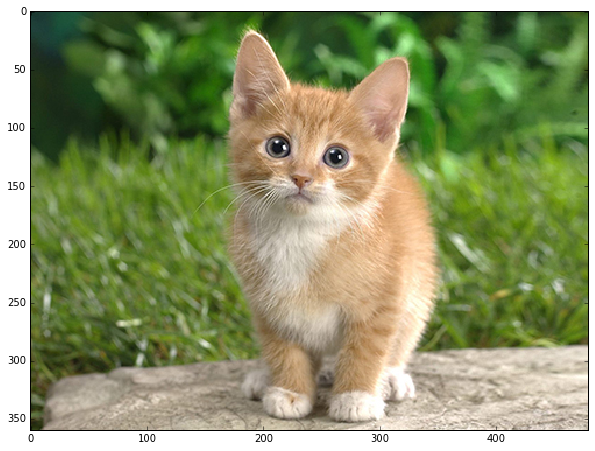

In [6]:
image = caffe.io.load_image('./caffe/examples/images/cat.jpg')
# image = caffe.io.load_image('./dog.jpg')
plt.imshow(image)

* 불러온 이미지에 전처리 과정과 forward pass를 수행합니다.

In [7]:
transformed_image = transformer.preprocess('data', image) # 전처리 과정 수행
net.blobs['data'].data[...] = transformed_image # Network의 입력으로 전달
output = net.forward()['prob'][0] # Forward Pass 수행 후 ['prob'][0]을 사용하여 0번째 이미지의 확률값을 전달

각 Class의 확률을 그래프로 그리면 다음과 같습니다.

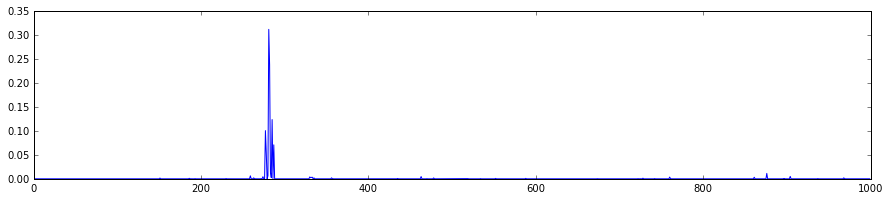

In [8]:
plt.figure(figsize=(15, 3))
plt.plot(output.flat)

* argmax를 사용하여 가장 높은 확률을 갖는 label index를 출력할 수 있습니다.
* label index와imagenet의 class-label 매핑 정보 (synset_words.txt)를 사용하여 주어진 이미지의 class를 판별 할 수 있습니다.

In [9]:
class_index = output.argmax()
print 'predicted class idx is:  ', class_index
print 'predicted class name is: ', labels[class_index]


predicted class idx is:   281
predicted class name is:  n02123045 tabby, tabby cat


* 가장 확률이 높은 5개의 class를 순서대로 나타내면 아래와 같습니다.

In [10]:
top_inds = output.argsort()[::-1][:5]
print 'Top5 probs and class names:'
zip(output[top_inds], labels[top_inds])

Top5 probs and class names:


[(0.31243721, 'n02123045 tabby, tabby cat'),
 (0.23797116, 'n02123159 tiger cat'),
 (0.12387248, 'n02124075 Egyptian cat'),
 (0.1007568, 'n02119022 red fox, Vulpes vulpes'),
 (0.070957348, 'n02127052 lynx, catamount')]

## 2. Filters & activations visualization 

* Network가 잘 학습되었는지와 각각의 Layer이 어떻게 작동되고 있는지는 filter와 activation을 시각화하여 확인할 수 있습니다.

* Caffe blob 의 기본 구조는 4차원이며, 이때 각 dimension은 `(batch_size, channel_dim, height, with)` 입니다.

* Filter와 Activation은 PyCaffe에서 `OrderedDict`의 형식을 따르며, `net.blobs`로 접근 가능합니다.

* 각 Layer의 output blob shape (dimension)은 아래와 같이 확인 가능합니다.

In [11]:
for layer_name, blob in net.blobs.iteritems(): 
    print layer_name + '\t' + str(blob.data.shape) #모든 layer에 대해서 blob.data.shape를 출력한다

data	(1, 3, 227, 227)
conv1	(1, 96, 55, 55)
pool1	(1, 96, 27, 27)
norm1	(1, 96, 27, 27)
conv2	(1, 256, 27, 27)
pool2	(1, 256, 13, 13)
norm2	(1, 256, 13, 13)
conv3	(1, 384, 13, 13)
conv4	(1, 384, 13, 13)
conv5	(1, 256, 13, 13)
pool5	(1, 256, 6, 6)
fc6	(1, 4096)
fc7	(1, 4096)
fc8	(1, 1000)
prob	(1, 1000)


* 같은 방법으로 learning된 parameter blob shape(dimension)을 확인 할 수 있습니다. 
* learning된 parameter는 filter weight와 bias가 존재하며, 이때 [0]번째 index는 filter weight, [1]번째 index는 bias를 의미합니다.

In [12]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


* 아래의 함수는 4차원 convolution filter weight를 시각화 하는 함수입니다.

In [13]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

* 위에서 정의된 vis_square 함수를 이용하면 `conv1` filter를 아래와 같이 시각화 할 수 있습니다. 

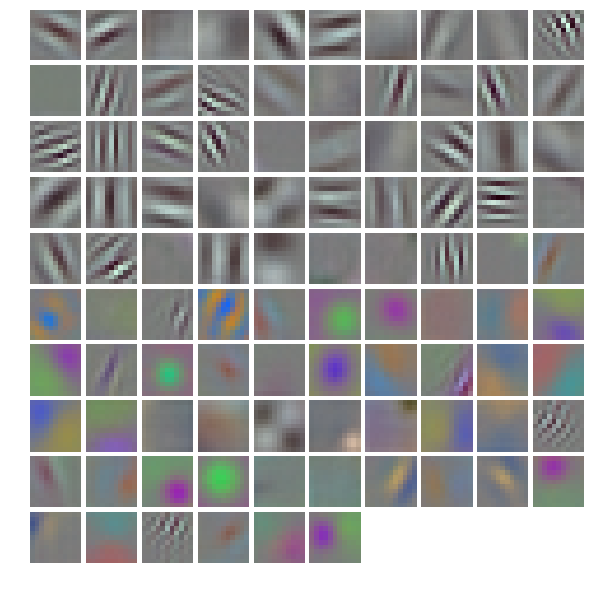

In [14]:
filters = net.params['conv1'][0].data # Conv1의 filter weight를 시각화합니다.
vis_square(filters.transpose(0, 2, 3, 1))

* Conv1 layer를 통과한 activation 역시 비슷한 방법으로 시각화 할 수 있습니다.

In [15]:
feat = net.blobs['conv1'].data[0] # Conv1 data blob을 시각화합니다.
vis_square(feat)

* 위의 Visualization 예제에서 'conv1'을 다른 layer 이름으로 변경하여 다양한 layer의 filter weight와 activation을 그려보세요.

### 3. Excercise

* 다양한 이미지에 대해서 image classification을 수행해 보세요.
* `!wget -O image.jpg $my_image_url` 명령어를 사용하여 웹상의 이미지를 image.jpg로 다운로드 받을 수 있습니다.
* 앞에서 다룬 caffe.io.load_image, transformer, net.forward() 함수를 사용하여 다운로드 받은 이미지의 class를 분류해 보세요.

In [ ]:
# 이미지 주소 입력 (원하시는 이미지 주소를 입력하세요)
my_image_url = "http://g-ecx.images-amazon.com/images/G/01/img15/pet-products/small-tiles/23695_pets_vertical_store_dogs_small_tile_8._CB312176604_.jpg"
!wget -O image.jpg $my_image_url
#---------------------------------------#
# Caffe.io.load_image를 사용하여 이미지 ('image.jpg')를 읽어오세요

# plt.imshow()를 사용하여 다운로드 된 이미지를 출력하세요.

# 불러온 이미지에 transformer를 사용하여 전처리 과정을 수행하세요

# 전처리된 이미지를 network의 data blob에 복사하세요

# network의 forward pass를 수행하세요

# forward pass의 결과로부터 확률값을 얻고, 확률이 가장 높은 class index를 출력하세요

# class index로부터 실제 class name을 출력하세요
